In [186]:


import pandas as pd
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')


Набор данных и переменные
Данные, которыми мы располагаем, получены от 90 189 игроков, которые установили игру во время выполнения AB-теста. Переменными являются:

userid - уникальный номер, который идентифицирует каждого игрока.
version - был ли игрок помещен в контрольную группу (gate_30 - ворота на 30-м уровне) или в группу с перемещенными воротами (gate_40 - ворота на 40-м уровне).
sum_gamerounds - количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.
retention_1 - вернулся ли плеер и играл ли он через 1 день после установки?
retention_7 - вернулся ли плеер и играл ли он через 7 дней после установки?
Когда игрок устанавливал игру .

In [187]:
# df = pd.read_csv('cookie_cats2.csv')
# df.head(10)
df = pd.read_excel('cats1.xlsx')
df.head


<bound method NDFrame.head of         userid  version  sum_gamerounds  retention_1  retention_7
0          116  gate_30               3            0            0
1          337  gate_30              38            1            0
2          377  gate_40             165            1            0
3          483  gate_40               1            0            0
4          488  gate_40             179            1            1
...        ...      ...             ...          ...          ...
90184  9999441  gate_40              97            1            0
90185  9999479  gate_40              30            0            0
90186  9999710  gate_30              28            1            0
90187  9999768  gate_40              51            1            0
90188  9999861  gate_40              16            0            0

[90189 rows x 5 columns]>

Всего игроков

In [188]:
df["userid"].nunique()


90189

In [189]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [190]:
df.describe()


,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [191]:
df.isna().sum()


userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Проверяем количество игроков в каждой группе А/B

In [192]:
df.groupby("version")[["userid"]].nunique()


,userid
version,
gate_30,44700
gate_40,45489


 Cтром график распределения количества игровых раундов, сыгранных игроками в течение их первой недели игры.

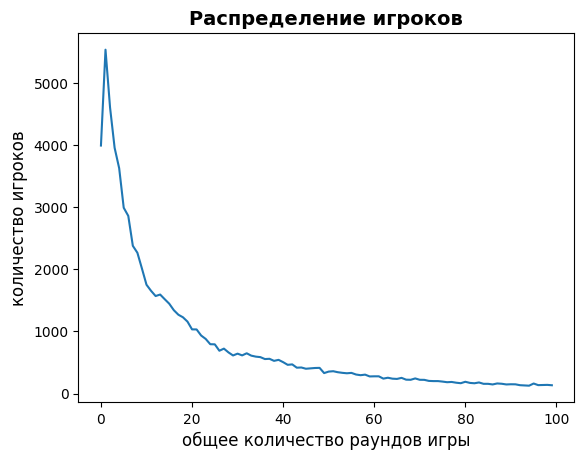

In [193]:
plot_df = df.groupby("sum_gamerounds")["userid"].count()
ax = plot_df.head(100).plot()
plt.title("Распределение игроков", fontweight="bold", size=14)
plt.xlabel("общее количество раундов игры", size=12)
plt.ylabel("количество игроков", size=12)
plt.show()


На приведенном выше графике мы видим, что некоторые игроки устанавливают игру, но затем никогда в нее не играют (0 игровых раундов). Давайте выясним, сколько их всего.

In [194]:
df[df["sum_gamerounds"] == 0]["userid"].count()


3994

3994 игрока никогда не играли в эту игру, просто установили ее.

Далее смотрим, что такое 1-дневное и 7-дневное удержание в целом.

In [195]:
df_retention = df[["retention_1", "retention_7"]].mean()*100
print(f"1-day retention ratio: {round(df_retention[0],2)}% \
      \n7-days retention ratio: {round(df_retention[1],2)}%")


1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


18 процентов игроков возвращаются через 7 дней после установки игры.
Теперь, когда у нас есть ориентир, давайте посмотрим, как различаются показатели удержания в двух группах A / B.

In [196]:
df_retention_ab = df.groupby("version").agg(
    {"userid": "count", "retention_1": "mean", "retention_7": "mean", "sum_gamerounds": "sum"})
df_retention_ab


,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


Наблюдалось небольшое снижение удержания в течение 1 дня, когда ворота были перемещены на 40-й уровень (44,2%) по сравнению с контрольной группой, когда они были на 30-м уровне (44,8%).

Опять же, наблюдалось снижение 7-дневного удержания, когда ворота были перемещены на 40-й уровень (18,2%) по сравнению с контрольной группой, когда они были на 30-м уровне (19,8%).

Это небольшое изменение, но даже небольшие изменения в удержании могут оказать большое влияние. Но хотя мы уверены в разнице в данных, насколько мы должны быть уверены в том, что врата на 40-м уровне будут хуже в будущем?

Есть несколько способов, которыми мы можем получить достоверность этих показателей удержания. Здесь…

### Определение метода

Мы будем использовать bootstrapping для A / B тестирования. Основная идея начальной загрузки заключается в том, что вывод о совокупности из выборочных данных (sample → population) может быть смоделирован путем повторной выборки данных выборки и выполнения вывода о выборке из повторно отобранных данных (resampled → sample). Поскольку совокупность неизвестна, истинная погрешность выборочной статистики по отношению к ее значению в совокупности неизвестна. В bootstrap-повторных выборках "совокупность" на самом деле является выборкой, и это известно; следовательно, качество вывода "истинной" выборки из повторно отобранных данных (resampled → sample) поддается измерению

Этапы тестирования:

1. Создание 500 выборок набора данных (начальная загрузка)
2. Расчет задержек на 1 день и 7 дней для групп A/B
3. Построение графиков загрузочных дистрибутивов
4. Расчет разницы в показателях удержания между двумя группами A/B
5. Вычисление вероятности того, что 1-дневные и 7-дневные задержки будут больше, когда ворота находятся на уровне 30
6. Оценка результатов и выработка рекомендаций

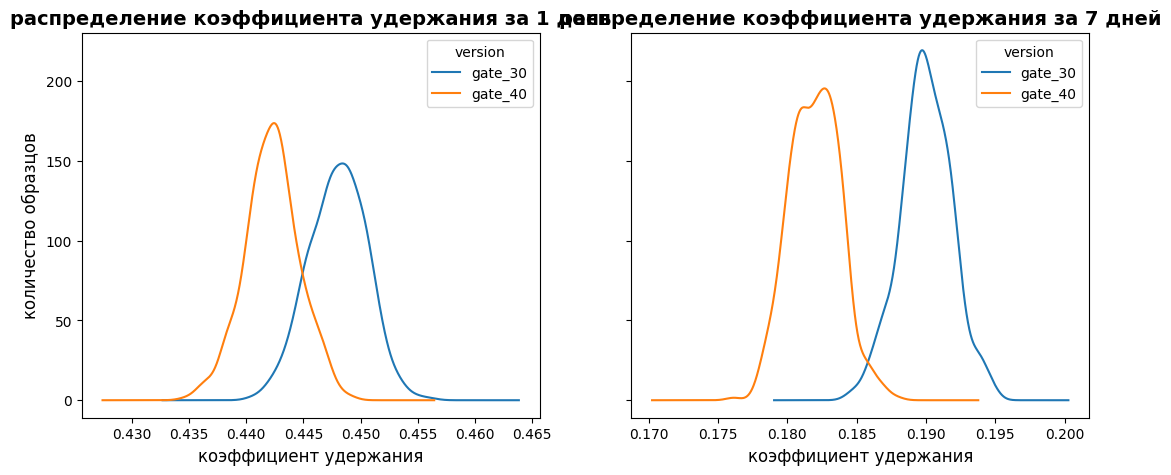

In [197]:
# Создание списка с загрузочными средствами для каждой группы A/B
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby(
        'version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby(
        'version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)

# Преобразование списка в фрейм данных
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# График оценки плотности ядра для загрузочных распределений
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("коэффициент удержания", size=12)
ax1.set_ylabel("количество образцов", size=12)
ax1.set_title("распределение коэффициента удержания за 1 день",
              fontweight="bold", size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("коэффициент удержания", size=12)
ax2.set_title("распределение коэффициента удержания за 7 дней",
              fontweight="bold", size=14)
plt.show()


Эти два распределения, приведенные выше, представляют собой начальную неопределенность в отношении того, каким может быть базовое 1-дневное и 7-дневное удержание для двух групп A / B. Просто взглянув на этот график, мы можем увидеть, что, по-видимому, есть некоторые признаки разницы, хотя и небольшой. Давайте увеличим масштаб различий.

(Обратите внимание, что в этом блокноте мы ограничили количество репликаций bootstrap до 500, чтобы ускорить вычисления. В разделе "производство" мы, вероятно, увеличили бы это число до гораздо большего, скажем, до 10 000.)

In [198]:
# Добавление столбца с разницей в % между двумя группами A/B
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']
                    ) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']
                    ) / boot_7d['gate_40'] * 100)


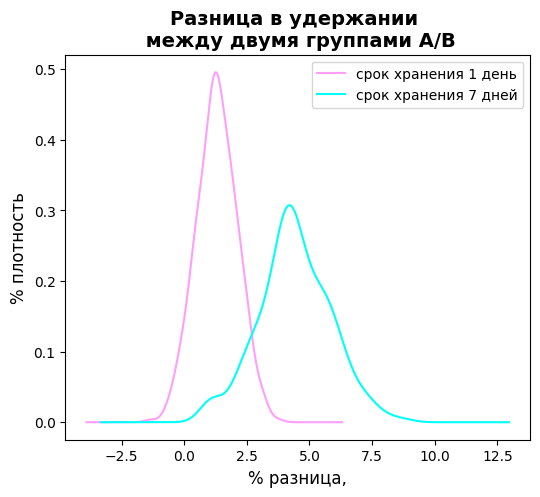

In [199]:
# Построение графика разницы в процентах начальной загрузки
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff9ffa", label="срок хранения 1 день")
boot_7d['diff'].plot.kde(ax=ax1, c="#00fffa", label="срок хранения 7 дней")
ax1.set_xlabel("% разница,", size=12)
ax1.set_ylabel("% плотность", size=12)
ax1.set_title("Разница в удержании \n между двумя группами A/B",
              fontweight="bold", size=14)
plt.legend()
plt.show()


Из этих графиков мы можем видеть, что наиболее вероятная разница в процентах составляет около 1% - 2% при удержании в течение 1 дня. При 7-дневном хранении наиболее вероятная разница в процентах составляет около 2-5%. Более того, большая часть распределения превышает 0% в пользу врат на 30-м уровне. Но какова вероятность того, что разница превысит 0%? Давайте подсчитаем и это тоже.

In [200]:
# Вычисление вероятности того, что задержка на 1 день будет больше, когда ворота находятся на уровне 30
prob_1 = (boot_1d['diff'] > 0).sum()/len(boot_1d['diff'])


In [201]:
# Вычисление вероятности того, что 7-дневное удержание будет больше, когда ворота находятся на уровне 30
prob_7 = (boot_7d['diff'] > 0).sum()/len(boot_7d['diff'])


In [202]:
# Распечатка вероятности
print(f"Вероятность удержания в течение 1 дня выше, когда ворота находятся на уровне 30: {round(prob_1,2)*100}% \
      \nВероятность того, что 7-дневное удержание будет больше, когда ворота находятся на уровне 30: {(prob_7)*100}% ")


Вероятность удержания в течение 1 дня выше, когда ворота находятся на уровне 30: 95.0%       
Вероятность того, что 7-дневное удержание будет больше, когда ворота находятся на уровне 30: 100.0% 


Результат начальной загрузки говорит нам о том, что есть убедительные доказательства 99,8% вероятности того, что 7-дневное удержание выше, когда ворота находятся на 30-м уровне, чем когда они находятся на 40-м.

Вывод таков: если мы хотим поддерживать высокий уровень удержания — как 1-дневное, так и 7-дневное удержание — нам не следует перемещать ворота с 30-го уровня на 40-й. Конечно, есть и другие показатели, на которые мы могли бы обратить внимание, например, количество сыгранных раундов или количество внутриигровых покупок, сделанных двумя AB-группами. Но удержание - один из самых важных показателей. 